<a href="https://colab.research.google.com/github/LC1332/simple-face-recognition/blob/main/notebook/minimal_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/LC1332/simple-face-recognition

%cd simple-face-recognition

Cloning into 'simple-face-recognition'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 11.32 KiB | 11.32 MiB/s, done.
/content/simple-face-recognition


下载例子图片

In [2]:
!pip install -q mediapipe
# opencv-python
!wget https://avatars.githubusercontent.com/u/5266090?v=4
!mv 5266090?v=4 example.png

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

这里mediapipe的安装可能需要一些时间

---

正规化

In [3]:
from MPCropAndNorm import MPCropAndNorm

import cv2
detector = MPCropAndNorm()
image = cv2.imread('example.png')
faces = detector.crop_and_norm(image)

cropped_face = faces[0]

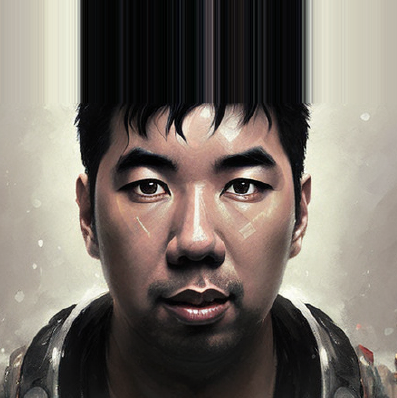

True

In [4]:
from google.colab.patches import cv2_imshow
cv2_imshow(cropped_face)
save_name = "cropped_face.jpg"
cv2.imwrite(save_name, cropped_face)

---
抽取CLIP特征

In [5]:
from CLIPExtractor import CLIPExtractor

# 这里实际上是 openai/clip-vit-base-patch16

extractor = CLIPExtractor()
features = extractor.extract([save_name])
raw_clip_feature = features[0]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


---

project到人脸识别特征

这里可能需要hugging face的token授权 如果报错就自己登陆一下

In [6]:
from huggingface_hub import hf_hub_download

lda_model_path = hf_hub_download(repo_id="silk-road/simple-face-recognition", filename="lda_openai_clip_model.pkl")

# load lda
import pickle
with open(lda_model_path, 'rb') as f:
    lda_model = pickle.load(f)

lda_openai_clip_model.pkl:   0%|          | 0.00/314M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
def project_to_lda(feature):
    return lda_model.transform([feature])


In [8]:
face_recognition_feature = project_to_lda(raw_clip_feature)

In [9]:
print(face_recognition_feature.shape)

(1, 512)
